In [167]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import matthews_corrcoef, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
# from sklearn import metrics
import data_cleaner as dc
import ML_func as ml

In [168]:
y_train = pd.read_csv("../clean_data/mci_wv1go_imp.csv")["progress"]
y_test = pd.read_csv("../clean_data/mci_wv23_imp.csv")["progress"]

In [169]:
def bi_scores(y_true, y_pred, y_prob):     # evaluation metrics for binary case
    acc = format(np.mean(y_true == y_pred),'.4f' )      # accuracy
    auc = roc_auc_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kp = cohen_kappa_score(y_true, y_pred)
    return {'MCC':mcc, 'Accuracy':acc, 'AUC':auc, 'F1-Score':f1, 'Kappa':kp}

In [1]:
x1 = dc.load_py("../output/result_cat_imp.pkl")
confusion_matrix(y_test, x1["test_pred"])

NameError: name 'dc' is not defined

In [179]:
from glob import glob
files = glob("output/result_*_imp*")
methods = []
train_scores = []  # save the dict outputs
test_scores = []
test_probs = []
for fl in files:
    res = dc.load_py(fl)
    test_pred = res["test_pred"]
    train_pred = res["train_pred"]
    test_prob = res["test_prob"]
    test_probs.append(test_prob)
    train_prob = res["train_prob"]
    test_scores.append(bi_scores(y_test, test_pred, test_prob) )
    train_scores.append(bi_scores(y_train, train_pred, train_prob) )
    methods.append(fl.split('_', 2)[1])
train_scores = pd.DataFrame(train_scores).round(4)
test_scores = pd.DataFrame(test_scores).round(4)  
train_scores.index = test_scores.index = methods

In [180]:
algorithms = ["XGBoost", "GBM", "Logistic Regression", "LightGBM", "SVM", "Random Forest", "CatBoost"]
train_scores.index = test_scores.index = algorithms
test_scores = test_scores.sort_values("MCC", ascending=False)
test_scores.to_csv("output/table1.csv")
train_scores.to_csv("output/train_table.csv")


In [181]:
test_scores

,MCC,Accuracy,AUC,F1-Score,Kappa
CatBoost,0.4453,0.9120,0.9312,0.4211,0.3848
XGBoost,0.3543,0.9480,0.8829,0.3810,0.3539
LightGBM,0.3503,0.9320,0.8954,0.3704,0.3370
GBM,0.2692,0.9240,0.8792,0.2963,0.2590
SVM,0.2496,0.9160,0.8667,0.2759,0.2358
Random Forest,0.2347,0.9520,0.8840,0.2500,0.2268
Logistic Regression,0.2041,0.8080,0.7783,0.2000,0.1429


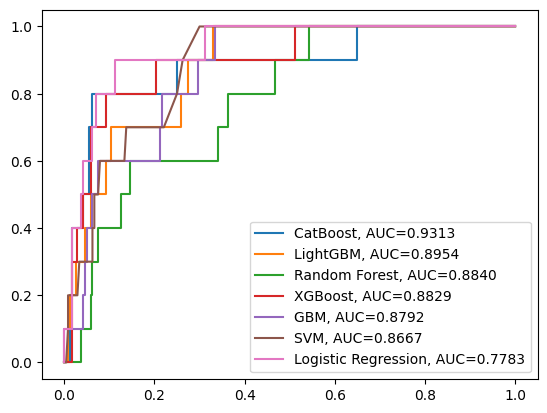

In [174]:
# ROC curve
plt.figure(0).clf()
labels = []  # to reorder using auc value
for i in range(7):
    y_pred = test_probs[i]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = format(roc_auc_score(y_test, y_pred), '.4f')
    label = f"{algorithms[i]}, AUC={str(auc)}"
    labels.append((auc, label))
    plt.plot(fpr,tpr,label=label)
    
# sort the labels based on auc values
labels.sort(reverse=True)
sorted_labels = [label for auc, label in labels]

plt.legend(sorted_labels)
plt.savefig('output/roc_curve.tiff', dpi=300)

### Feature Importance

In [177]:
from operator import itemgetter
files = glob("output/*_feat.pkl")
table2 = pd.DataFrame()
table2["rank"] = pd.Series(range(1,11))  
for fl in files:
    raw = dc.load_py(fl)
    raw["LDELTOTAL_BL"] = 0    # rm bl variable, redundant 
    # print(fl)
    top10 = dict(sorted(raw.items(), key = itemgetter(1), reverse = True)[:10]) 
    top10 = pd.DataFrame(list(top10.items()), columns=['Feature', 'Score'])
    table2 = pd.concat([table2, top10], axis=1)   
table2.columns = pd.MultiIndex.from_tuples((('Rank',''),
                                           ('XGBoost', 'Feature'), 
                                            ('XGBoost', 'normalized Score'), 
                                           ('Light GBM', 'Feature'), 
                                            ('Light GBM', 'normalized Score'), 
                                           ('CatBoost', 'Feature'), ('CatBoost', 'Score')) )
table2

Rank          XGBoost                         Light GBM                   \
                Feature normalized Score          Feature normalized Score   
0    1       PTAU_UPENN         1.333333       PTAU_UPENN         0.846154   
1    2          MidTemp         0.904762              FAQ         0.615385   
2    3        TAU_UPENN         0.857143              AGE         0.564103   
3    4              FAQ         0.809524  RAVLT_immediate         0.512821   
4    5              AGE         0.761905          MidTemp         0.487179   
5    6  RAVLT_immediate         0.761905        TAU_UPENN         0.410256   
6    7       Ventricles         0.666667       EcogSPLang         0.358974   
7    8       EcogSPLang         0.619048            CDRSB         0.307692   
8    9      EcogSPTotal         0.619048        LDELTOTAL         0.307692   
9   10         IMAGEUID         0.619048             AV45         0.282051   

          CatBoost             
           Feature      Score  
0              FAQ  13.117129  
1       PTAU_UPENN   6.530929  
2            CDRSB   6.400816  
3          MidTemp   4.998855  
4  RAVLT_immediate   4.775101  
5        LDELTOTAL   4.197380  
6           ADAS13   4.134868  
7       EcogSPLang   3.655634  
8      Hippocampus   3.451002  
9       mPACCdigit   3.233384

In [178]:
table2.to_csv("output/table2.csv", index=False)